In [10]:
# !wget "https://raw.githubusercontent.com/Henriquelay/AI-classes/main/Trab1/hemofilia.csv" -O "hemofilia.csv" -nc

# Data ingestion
import pandas as pd

# My school enrollment id ends with `4`, so I'm assigned to TaskI, which is to classify the severity of hemophilia
assigned_task = "Calculated_Severity"

df = pd.read_csv("hemofilia.csv")
df.head()

,AA_HGVS,AA_Legacy,aa1,AA_dist,psi,phi,bfactor,areaSAS,areaSES,kdHydrophobicity,ConsurfDB,degree,betweenness,closeness,burts,pr,auth,kcore,Calculated_Severity
0,26,7,Leu,1.622514,150.866429,-107.867773,146.53,4.380023,20.015846,3.8,-793.0,8.0,0.010313,0.115715,0.225146,0.000859,0.074260,4.0,Severe
1,28,9,Ala,1.523528,18.239183,168.251651,139452.00,0.000000,0.000000,1.8,-1019.0,10.0,0.004677,0.107229,0.179909,0.001077,0.081676,4.0,Moderate
2,29,10,Val,1.568551,116.506984,-35.703606,193867.00,10.603600,41.534812,4.2,-746.0,7.0,0.002008,0.101614,0.239194,0.000837,0.043540,4.0,Severe
3,31,12,Leu,1.641493,177.755055,-104.656175,154735.00,45.264135,75.880436,3.8,-134.0,7.0,0.002169,0.097581,0.263617,0.000879,0.034803,4.0,Moderate
4,34,15,Asp,1.602138,-66.129605,-99.559307,195175.00,27.504607,44.515711,-3.5,-925.0,4.0,0.001263,0.098256,0.373760,0.000559,0.004828,4.0,Mild


In [11]:
# Data preprocessing
# Converting string labels to numerical
from sklearn import preprocessing
import numpy as np

encoder = preprocessing.OrdinalEncoder(dtype=int)
nominal_columns = df.select_dtypes(include=["object"])
for col in nominal_columns.columns:
    df[col] = encoder.fit_transform(df[[col]])
df.head()

# Splitting data into features and target
X, y = df.drop(columns=assigned_task), df[assigned_task]

A primeira etapa consiste no treino e teste com 3 rodadas de validação cruzada estratificada de 10 folds do classificador que não possui hiperparâmetros, isto é, os classificadores ZR e NB.

In [12]:
# Split the data into training and test sets
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats


# Random state value set assignment specification
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)


def scores(model, rkf = rkf) -> dict[str, float]:
    scorings = "accuracy"
    scores = cross_val_score(model, X, y, scoring=scorings, cv=rkf, n_jobs=-1)
    scores_acc = scores
    scores_mean = scores_acc.mean()
    scores_std = scores_acc.std()
    inf, sup = stats.norm.interval(
        0.95, loc=scores_mean, scale=scores_std / np.sqrt(len(scores_acc))
    )
    return {
        "mean": scores_mean,
        "std": scores_std,
        "inf": inf if not np.isnan(inf) else 0.0,
        "sup": sup if not np.isnan(sup) else 0.0,
        "raw": scores_acc,
    }


base_pipeline = Pipeline(
    [
        # Placing the scaler in the pipeline for it to be used in the folds individually
        ("scaler", StandardScaler()),
        ("model", None),
    ],
    memory="tmp",
)

In [13]:
from sklearn.dummy import DummyClassifier

zeroR = DummyClassifier(strategy="most_frequent")
zeroR_scores = scores(zeroR)
print(f"ZeroR: {({key: value for key, value in zeroR_scores.items() if key != 'raw'})}")

zeroR_pipeline = base_pipeline.set_params(model=zeroR)
zeroR_pipeline_scores = scores(zeroR_pipeline)
print(f"ZeroR pipeline: {({key: value for key, value in zeroR_pipeline_scores.items() if key != 'raw'})}")

ZeroR: {'mean': 0.46265969802555157, 'std': 0.00828233900723864, 'inf': 0.4596959555359453, 'sup': 0.46562344051515786}
ZeroR pipeline: {'mean': 0.46265969802555157, 'std': 0.00828233900723864, 'inf': 0.4596959555359453, 'sup': 0.46562344051515786}


In [14]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes_scores = scores(naive_bayes)
print(f"Naive Bayes: {({key: value for key, value in naive_bayes_scores.items() if key != 'raw'})}")

naive_bayes_pipeline = base_pipeline.set_params(model=naive_bayes)
naive_bayes_pipeline_scores = scores(naive_bayes_pipeline)
print(f"Naive Bayes pipeline: {({key: value for key, value in naive_bayes_pipeline_scores.items() if key != 'raw'})}")

Naive Bayes: {'mean': 0.5414440572977158, 'std': 0.06829302584930359, 'inf': 0.5170061609164561, 'sup': 0.5658819536789755}
Naive Bayes pipeline: {'mean': 0.4616918312040264, 'std': 0.0768989016887059, 'inf': 0.4341744182920836, 'sup': 0.4892092441159692}


A segunda etapa consiste no treino, validação e teste dos classificadores que precisam de ajuste de hiperparâmetros, isto é, os classificadores DT, KNN, MLP, RF e HP. Neste caso o procedimento de treinamento, validação e teste será realizado através de 3 rodadas de ciclos aninhados de validação e teste, com o ciclo interno de validação contendo 4 folds e o externo de teste com 10 folds. A busca em grade (grid search) do ciclo interno deve considerar os seguintes valores de hiperparâmetros de cada técnica de aprendizado:
```
Decision Tree: {'criterion': ['gini','entropy'],
                'max_depth': range(5, 10, 15, 25)}
K Nearest Neighbors: {‘n_neighbors’:[1,3,5,7,9,11,13,15]}
Multi Layer Perceptron: {'hidden_layer_sizes': [(100,),(10,)],
                        'alpha': [0.0001, 0.005],
                        'learning_rate': ['constant','adaptive']}
Random Forest: {'n_estimators': [50, 100],
                'max_depth': [10, None],
                'max_features': ['sqrt', None]}
HeterogeneousPooling: {‘n_samples’: [1, 2, 3, 4, 5, 6, 7, 9]}
```

In [15]:
rkf_out = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)
rkf_in = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=36851234)

def scores_gridsearch(model, param_grid) -> dict[str, float]:
    clf = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring="accuracy", cv=rkf_in, n_jobs=-1
    )
    return scores(clf, rkf=rkf_out)

In [16]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=11)
decision_tree_param_grid = {
    "max_depth": [5, 10, 15, 25],
    "criterion": ["gini", "entropy"],
}
decision_tree_scores = scores_gridsearch(decision_tree, decision_tree_param_grid)
print(
    f"Decision Tree: {({key: value for key, value in decision_tree_scores.items() if key != 'raw'})}"
)

decision_tree_pipeline = base_pipeline.set_params(model=decision_tree)
decision_tree_pipeline_scores = scores_gridsearch(
    decision_tree_pipeline,
    {f"model__{key}": value for key, value in decision_tree_param_grid.items()},
)
print(
    f"Decision Tree pipeline: {({key: value for key, value in decision_tree_pipeline_scores.items() if key != 'raw'})}"
)

Decision Tree: {'mean': 0.5742934572202864, 'std': 0.07275226671937282, 'inf': 0.5482598713089962, 'sup': 0.6003270431315765}
Decision Tree pipeline: {'mean': 0.5734998064266357, 'std': 0.0729088905172545, 'inf': 0.5474101744389582, 'sup': 0.5995894384143131}


In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn_param_grid = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]}
knn_scores = scores_gridsearch(knn, knn_param_grid)
print(
    f"K-Nearest Neighbors: {({key: value for key, value in knn_scores.items() if key != 'raw'})}"
)

knn_pipeline = base_pipeline.set_params(model=knn)
knn_pipeline_scores = scores_gridsearch(
    knn_pipeline,
    {f"model__{key}": value for key, value in knn_param_grid.items()},
)
print(
    f"K-Nearest Neighbors pipeline: {({key: value for key, value in knn_pipeline_scores.items() if key != 'raw'})}"
)

K-Nearest Neighbors: {'mean': 0.6021680216802169, 'std': 0.07142793142704715, 'inf': 0.5766083343587962, 'sup': 0.6277277090016375}
K-Nearest Neighbors pipeline: {'mean': 0.5389469608981803, 'std': 0.0743531797001114, 'inf': 0.5123405061609425, 'sup': 0.565553415635418}


In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=11)
mlp_param_grid = {
    "hidden_layer_sizes": [(100,), (10,)],
    "alpha": [0.0001, 0.005],
    "learning_rate": ["constant", "adaptive"],
}
mlp_scores = scores_gridsearch(
    mlp,
    mlp_param_grid,
)
print(
    f"Multi-layer Perceptron: {({key: value for key, value in mlp_scores.items() if key != 'raw'})}"
)

mlp_pipeline = base_pipeline.set_params(model=mlp)
mlp_pipeline_scores = scores_gridsearch(
    mlp_pipeline,
    {f"model__{key}": value for key, value in mlp_param_grid.items()},
)
print(
    f"Multi-layer Perceptron pipeline: {({key: value for key, value in mlp_pipeline_scores.items() if key != 'raw'})}"
)

Multi-layer Perceptron: {'mean': 0.42351916376306614, 'std': 0.10917446622794154, 'inf': 0.38445230063937025, 'sup': 0.46258602688676204}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

Multi-layer Perceptron pipeline: {'mean': 0.5832365466511809, 'std': 0.07117527037014619, 'inf': 0.5577672712664307, 'sup': 0.608705822035931}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11, n_jobs=-1)
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, None],
    "max_features": ["sqrt", None],
}
rf_scores = scores_gridsearch(
    rf,
    rf_param_grid,
)
print(
    f"Random Forest: {({key: value for key, value in rf_scores.items() if key != 'raw'})}"
)

rf_pipeline = base_pipeline.set_params(model=rf)
rf_pipeline_scores = scores_gridsearch(
    rf_pipeline,
    {f"model__{key}": value for key, value in rf_param_grid.items()},
)
print(
    f"Random Forest pipeline: {({key: value for key, value in rf_pipeline_scores.items() if key != 'raw'})}"
)

Random Forest: {'mean': 0.6482578397212543, 'std': 0.05196912747957409, 'inf': 0.6296612680131454, 'sup': 0.6668544114293632}
Random Forest pipeline: {'mean': 0.6466511807975224, 'std': 0.053329528615441435, 'inf': 0.6275678047403335, 'sup': 0.6657345568547113}


O classificador Heterogeneous Pooling é um combinado de classificadores heterogêneos que usa como classificadores base: Árvore de Decisão (DT), Naive Bayes Gaussiano (NB) e K Vizinhos Mais Proximo (KNN), sempre com valores default do `sklearn` para seus hiperparâmetros. O único parâmetro do método Heterogeneous Pooling é o `n_samples`, que indica o número de vezes que os classificadores base serão usados para gerar o combinado. Por exemplo, se `n_samples` é igual a 3, o combinado será composto por 9 classificadores: 3 árvores de decisão, 3 naive bayes e 3 vizinhos mais próximos. Para diferenciar os classificadores de mesmo tipo em um combinado, o primeiro deles será treinado com a base de treino original e os demais serão treinados com uma base de treino diferente, obtida a partir da base de treino original através de um método para seleção de características. O método consiste em selecionar aleatoriamente um número de características, variando de 2 até o `número de características - 1` e, a partir desse número, devem ser selecionadas as $N$ características através de uma roleta onde a chance de uma característica ser escolhida é baseada no seu [ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html). **Atenção, uma característica não deve ser escolhida mais de uma vez.** Assim, toda vez que uma característica é selecionada a roleta deve redistribuir as chances das demais características
O critério de decisão para classificar uma instância é a votação majoritária, ou seja, deve-se escolher a classe mais escolhida dentre os classificadores que compõem o combinado. Em caso de empate, a classe escolhida deve ser a mais frequente na base de dados de treino original dentre as que empataram na votação.

O pseudo código a seguir mostra como o HP é obtido a partir de uma base de dados de treino:
```pseudo
- Obter e armazenar a ordenação das classes de acordo com a ocorrência nos exemplos na
base de treino (ordenar decrescentemente da mais frequente para a menos frequente)
- Para cada um dos `n_samples` faça
    - Se for a primeira iteração então
        - Usar a base original para treino dos classificadores
    - Senão
        - Escolher o número de características aleatoriamente (2 a n_caracteristicas-1)
        - Montar a base selecionando as características utilizando o método da roleta.
    - Fim-se
    - Treinar os classificadores KNN, NB, DT na base de treino corrente e incluí-los no combinado de classificadores
- Fim-para
```

O pseudo código seguinte mostra como o combinado HP é usado para classificar um exemplo
da base de dados de teste:
```pseudo
- Para cada um dos classificadores individuais do combinado faça
    - Obter a classificação do exemplo usando o classificador individual e armazenar a classe selecionada
- Fim-para
- Contar quantas vezes cada classe foi selecionada e obter a(s) mais votada(s)
- Se mais de uma classe for a mais votada então
    - Retornar a classe mais votada mais frequente na base de treino dentre as que empataram
- Senão
    - Retornar a classe mais votada
- Fim-se
```

In [20]:
from sklearn.ensemble import VotingClassifier


class HeterogenousPooling(VotingClassifier):
    estimators_ = [
        GaussianNB(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(n_jobs=-1),
    ]

    def __init__(self):
        super().__init__(n_jobs=-1)

    def fit(self, X, y, sample_weight=None):
        # TODO attribute dropping shananigan
        super()._raise_for_unsupported_routing(self, "fit", sample_weight=sample_weight)
        y_type = super().type_of_target(y, input_name="y")
        if y_type in ("unknown", "continuous"):
            # raise a specific ValueError for non-classification tasks
            raise ValueError(
                f"Unknown label type: {y_type}. Maybe you are trying to fit a "
                "classifier, which expects discrete classes on a "
                "regression target with continuous values."
            )
        elif y_type not in ("binary", "multiclass"):
            # raise a NotImplementedError for backward compatibility for non-supported
            # classification tasks
            raise NotImplementedError(
                f"{self.__class__.__name__} only supports binary or multiclass "
                "classification. Multilabel and multi-output classification are not "
                "supported."
            )

        self.le_ = super().LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        transformed_y = self.le_.transform(y)

        return super().fit(X, transformed_y, sample_weight)

    def predict(self, X):
        super().check_is_fitted(self)
        if self.voting == "soft":
            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self._weights_not_none)),
                axis=1,
                arr=predictions,
            )

        maj = self.le_.inverse_transform(maj)

        return maj

Os resultados de cada classificador devem ser apresentados numa tabela contendo a média das acurácias obtidas em cada fold, o desvio padrão e o intervalo de confiança a 95% de significância dos resultados, e também através do boxplot dos resultados de cada classificador em cada fold.

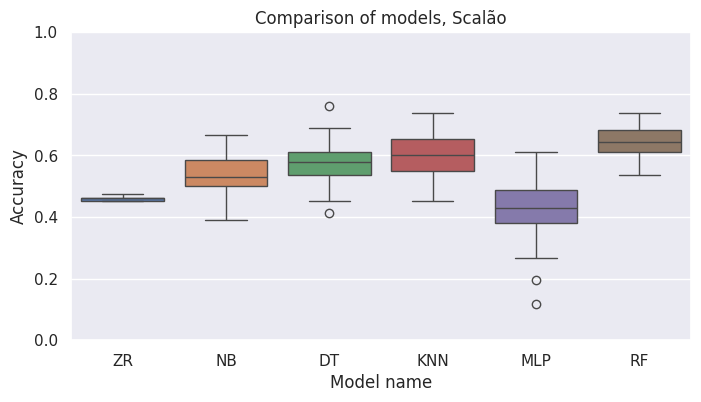

In [25]:
# Boxplot a comparison between all models
import matplotlib.pyplot as plt
import seaborn as sns

agg_data = {
    "ZR": zeroR_scores,
    "NB": naive_bayes_scores,
    "DT": decision_tree_scores,
    "KNN": knn_scores,
    "MLP": mlp_scores,
    "RF": rf_scores,
}

sns.set_theme(rc={"figure.figsize": (8, 4)})
fig, ax = plt.subplots()
ax.set(ylim=(0, 1))
ax.set_xlabel("Model name")
sns.boxplot(data={k: v["raw"] for k, v in agg_data.items()})
plt.ylabel("Accuracy")
plt.title("Comparison of models, Scalão")
plt.show()

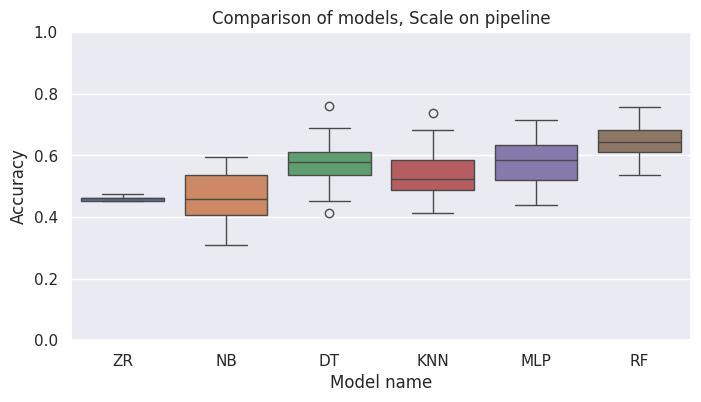

In [26]:
agg_pipeline_data = {
    "ZR": zeroR_pipeline_scores,
    "NB": naive_bayes_pipeline_scores,
    "DT": decision_tree_pipeline_scores,
    "KNN": knn_pipeline_scores,
    "MLP": mlp_pipeline_scores,
    "RF": rf_pipeline_scores,
}

sns.set_theme(rc={"figure.figsize": (8, 4)})
fig, ax = plt.subplots()
ax.set(ylim=(0, 1))
ax.set_xlabel("Model name")
sns.boxplot(data={k: v["raw"] for k, v in agg_pipeline_data.items()})
plt.ylabel("Accuracy")
plt.title("Comparison of models, Scale on pipeline")
plt.show()

In [23]:
get_stat = lambda stat_name: [
    model_stats[stat_name] for model_name, model_stats in agg_data.items()
]

pd.set_option('display.float_format', '{:.2f}'.format)
pd.DataFrame(
    {
        "Média": get_stat("mean"),
        "Desvio Padrão": get_stat("std"),
        "Limite Inferior": get_stat("inf"),
        "Limite Superior": get_stat("sup"),
    },
    index=pd.Index(agg_data.keys(), name="Método"),
)

,Média,Desvio Padrão,Limite Inferior,Limite Superior
Método,,,,
ZR,0.46,0.01,0.46,0.47
NB,0.54,0.07,0.52,0.57
DT,0.57,0.07,0.55,0.60
KNN,0.60,0.07,0.58,0.63
MLP,0.42,0.11,0.38,0.46
RF,0.65,0.05,0.63,0.67


Além das tabelas e dos gráficos bloxplot, será necessário apresentar também a tabela pareada dos resultados (p-values) dos testes de hipótese entre os pares de métodos. Na matriz triangular superior devem ser apresentados os resultados do **teste t pareado <u>corrigido</u>** (amostras dependentes) e na matriz triangular inferior devem ser apresentados os resultados do **teste não paramétrico de Wilcoxon**. Os valores da célula da tabela que rejeitarem a hipótese nula para um nível de significância de 95% devem ser escritos em negrito.

In [24]:
from typing import Iterable

from scipy.stats import wilcoxon, t
from math import sqrt
from statistics import stdev

table_raw_stats = {key: value["raw"] for key, value in agg_data.items()}

model_pairs = {
    frozenset({model1, model2})
    for model1 in agg_data.keys()
    for model2 in agg_data.keys()
    if model1 != model2
}


def corrected_dependent_ttest(
    data1: Iterable, data2: Iterable, n_training_samples: int, n_test_samples: int
) -> dict[str, float]:
    n = len(data1)
    differences = [(data1[i] - data2[i]) for i in range(n)]
    sd = stdev(differences)
    divisor = 1 / n * sum(differences)
    test_training_ratio = n_test_samples / n_training_samples
    denominator = sqrt(1 / n + test_training_ratio) * sd
    t_stat = divisor / denominator
    # degrees of freedom
    df = n - 1
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return {"t_stat": t_stat, "pvalue": p}


def hipothesis_tests(
    pair: frozenset[str], n_training_samples, n_test_samples
) -> tuple[float, float]:
    model_name1, model_name2 = pair
    dataset1 = table_raw_stats[model_name1]
    dataset2 = table_raw_stats[model_name2]
    # print(f"{model_name1} vs {model_name2}")
    return (
        corrected_dependent_ttest(
            dataset1, dataset2, n_training_samples, n_test_samples
        ),
        wilcoxon(dataset1, dataset2),
    )


samples_per_fold = df.shape[0] / rkf.get_n_splits()

table_stats = {
    pair: hipothesis_tests(
        pair,
        df.shape[0] - samples_per_fold,
        samples_per_fold,
    )
    for pair in model_pairs
}

model_order = list(agg_data.keys())


def table_stat(model1_name: str, model2_name: str):
    keys = list(agg_data.keys())
    stats = table_stats[frozenset({model1_name, model2_name})]
    if keys.index(model1_name) < keys.index(model2_name):
        # lower triangle, wilcoxon
        pvalue = stats[1].pvalue
    else:
        # upper triangle, dependent t-test
        pvalue = stats[0]["pvalue"]
    mark = "**" if pvalue < 0.05 else ""
    # Manually setting the number of decimal places
    # and marking the p-value if it's significantly low
    return f"{mark}{pvalue:.3f}{mark}"


table = [
    (
        model_name1
        if model_name1 == model_name2  # diagonal
        else (
            "Not tested"
            if frozenset({model_name1, model_name2})
            not in table_stats  # not tested, all zeroes
            else f"{table_stat(model_name1, model_name2)}"
        )
    )
    for model_name1 in agg_data.keys()
    for model_name2 in agg_data.keys()
]


pd.set_option("display.float_format", "{:.3f}".format)
pd.DataFrame(
    np.array(table).reshape(len(agg_data), len(agg_data)), index=None, columns=None
)

,0,1,2,3,4,5
0,ZR,**0.000**,**0.000**,**0.000**,0.092,**0.000**
1,**0.000**,NB,**0.029**,**0.011**,**0.000**,**0.000**
2,**0.000**,0.140,DT,0.186,**0.000**,**0.000**
3,**0.000**,0.058,0.344,KNN,**0.000**,**0.003**
4,0.188,**0.001**,**0.000**,**0.000**,MLP,**0.000**
5,**0.000**,**0.000**,**0.002**,**0.026**,**0.000**,RF
